# Show detailed distribution of the main VASCA selection variables
Enter the main notebook settings below.

In [1]:
region_name = "ALL_10-800" # #_ELAISN1
obs_filter = "NUV"
show_dtime_dist = False  # Show the time distribution between visits for all sources (currently computing intensive due to slow LC extraction)

### Look at the Pval distibutions for constant flux and position for different magnitudes

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import chi2

from regions import CircleSkyRegion
from astropy import units as uu
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import Table,Column
import numpy as np
from matplotlib.ticker import ScalarFormatter

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from vasca.utils import mag2flux, flux2mag, select_obs_filter,freq2period,period2freq,flux2mag_np,mag2flux_np, dd_filter2id
from vasca.tables_dict import dd_vasca_columns

obs_filter_id = dd_filter2id[obs_filter]

region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
tt_srcs = select_obs_filter(rg.tt_sources,obs_filter_id)
tt_srcs = tt_srcs[tt_srcs["flux"]>0] # Only sources with flux in the selected filter
tt_srcs["mag"] = flux2mag(tt_srcs["flux"].quantity).value

display(tt_srcs)
print("Nr. sources:",len(tt_srcs),"/",tt_srcs["sel"].sum())

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,mag
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,
int32,int32,float64,float64,float32,float32,float32,float32,float32,int64,float32,int32,bool,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float32,float32,float32
-1,38,150.06215895506952,2.20681993808272,0.15804908,-0.071402274,1.5916307,0.009567697,0.91565967,-1,-1.0,1,False,2.118276,0.091398075,-0.037488587,0.17730184,0.9945751,0.506444,-100.0,-10000.0,-1,2,13,0.7330711,0.12990916,23.085043
-1,168,150.196706683873,2.2999844721667193,0.06740033,-0.3388653,0.7013436,0.999337,0.6880611,851157,0.6316602,1,False,3.8940296,0.051362906,0.0007940975,0.59246856,0.8961588,0.86470884,-100.0,-10000.0,-1,3,12,0.48594198,0.042207737,22.424002
-1,46,150.13427731863484,2.0684185375174335,0.14737134,-0.34387457,1.1508969,0.90155727,0.7133178,852180,0.7747295,1,False,2.036833,0.08230834,-0.031936415,0.22967765,0.99961066,0.43907937,-100.0,-10000.0,-1,4,12,1.1394421,0.34207785,23.127611
-1,158,150.00171765516035,2.244749083957251,0.06720993,0.16078433,1.2089357,0.00027441027,0.909053,-1,-1.0,1,False,4.240035,0.05348609,-0.006767069,0.4383067,0.97779906,0.78624535,-100.0,-10000.0,-1,5,13,0.47217032,0.032640178,22.331577
-1,64,149.99459288789646,2.159966125109527,0.10115493,-0.0011858044,1.1783837,0.113326035,0.9964414,-1,-1.0,1,False,5.165225,0.09945955,-0.0036056458,0.83518106,0.7903714,0.8532278,-100.0,-10000.0,-1,6,11,0.4158093,0.05938978,22.117275
-1,29,150.28240158555622,2.218951809603797,0.17882307,-0.5834096,0.8640931,0.9444222,0.59782976,62932,0.19613238,1,False,1.8326699,0.10081773,-0.018589186,0.24413691,0.80458075,0.7673022,1.1828672,2.3351798,-1,10,11,0.63002706,0.13900365,23.24229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,6,0.0037302855905367847,-43.120853831131576,0.24839602,-0.22761111,0.15299843,0.53821486,0.5053321,-1,-1.0,1,False,23.201363,0.39324525,-0.0013402998,0.35150522,0.8091727,0.45603704,-100.0,-10000.0,-1,2790746,1,-1.0,-1.0,20.486217


Nr. sources: 1497490 / 8182


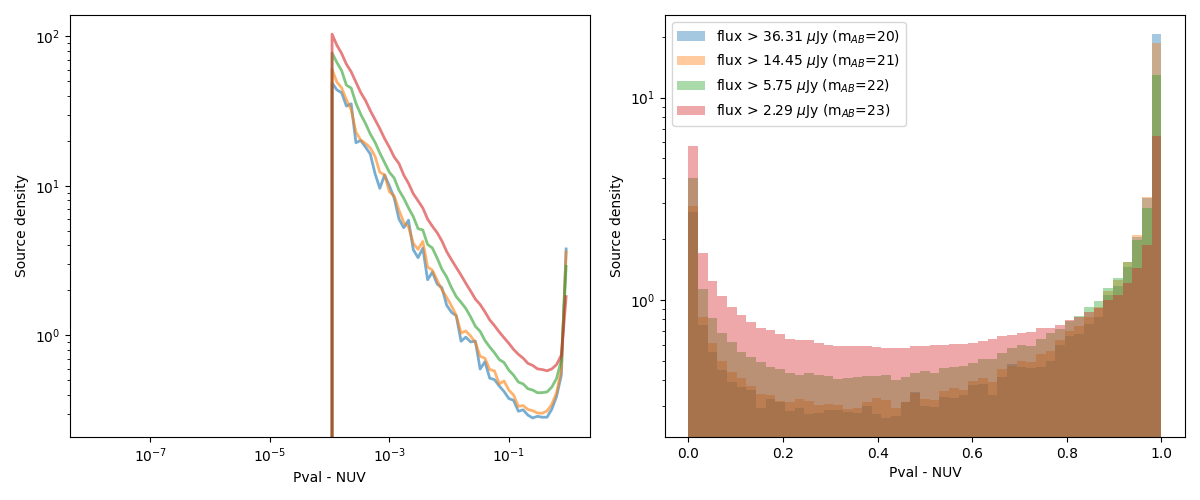

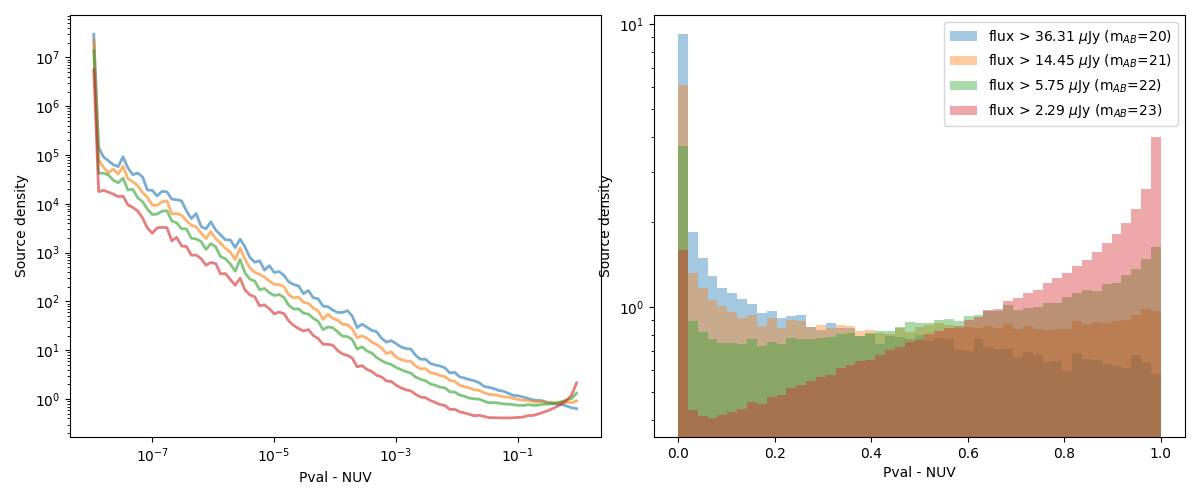

In [3]:
#Get pval data and saturate it at low Pval for better plotting
var_cpval = ["pos","flux"] #"pos" # 
sel_ndet = tt_srcs["nr_det"]>5
pval_min = 1e-8
for var in var_cpval:
    pvals = tt_srcs[var+"_cpval"]
    pvals = (pvals<pval_min+1e-12)*(pval_min+1e-12)+(pvals>pval_min)*pvals

    #if plot_logx:
    pval_bins_lg = np.linspace(np.log10(pval_min), 0, 101)
    pval_bins = np.power(10,pval_bins_lg)
    pval_bins_mean = (pval_bins[:-1]+pval_bins[1:])/2.
    
    pval_bins_lin = np.linspace(0, 1, 50)

    #Plotting for different magnitude cuts
    fig_pval, axs = plt.subplots(1, 2, figsize=(12, 5), squeeze=False, num=var, clear =True)
    axs = axs.flatten()
    flux_range = mag2flux(range(20,24))
    for flux_cut in flux_range:
        sel_flux = (tt_srcs["flux"].quantity>flux_cut)*sel_ndet

        pval_hist, bins = np.histogram(pvals[sel_flux], bins=pval_bins, density=True)
        axs[0].loglog(pval_bins_mean, pval_hist , lw=2, alpha=0.6, label=str(flux_cut))
        str_cut = str(round(flux_cut.value,2)) 
        str_mag_cut =  r" (m$_{AB}$="+str(int(flux2mag(flux_cut).value))+")"
        axs[1].hist(tt_srcs[sel_flux][var+"_cpval"], bins=pval_bins_lin, density=True ,label=r"flux > "+str_cut+" $\mu$Jy"+str_mag_cut,alpha=0.4)   #, ,cumulative=1


    axs[0].set_ylabel("Source density")
    axs[0].set_xlabel("Pval - "+obs_filter)
    axs[1].set_ylabel("Source density")
    axs[1].set_xlabel("Pval - "+obs_filter)
    plt.legend()
    plt.tight_layout()
    plt.semilogy()

### Flux variance as a function of magnitude (analog to Fig. 3 from Gezari et al. ApJ 2013)

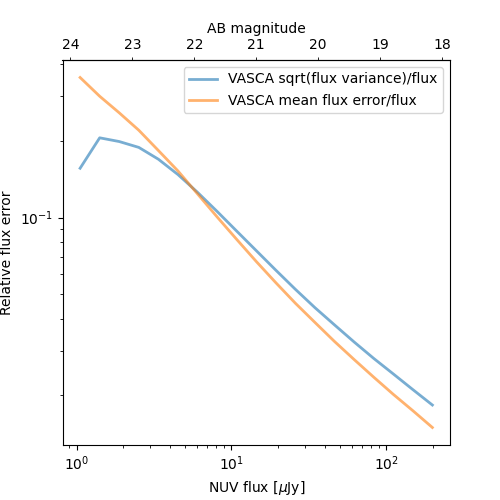

In [4]:
#Source selection
sel_cpval = tt_srcs["flux_cpval"]>0.001 #-1
#rg.tt_fields.add_index("field_id")
#fd = rg.tt_fields.loc["field_id", "GNU2605053246158405632"]
#sel_field = tt_srcs["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = tt_srcs["nr_det"]>10
sel_all = sel_cpval*sel_ndet#*sel_field
mag_bins = np.linspace(18,24,20)

flux_var_wght = np.sqrt(tt_srcs["flux_var"][sel_all])/tt_srcs["flux"][sel_all]
flux_var_hist, _= np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False, weights = flux_var_wght )
flux_rel_err_wght = tt_srcs["flux_err"][sel_all]*np.sqrt(tt_srcs["nr_det"][sel_all])/tt_srcs["flux"][sel_all]
flux_relerr_hist, mag_bins = np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False, weights = flux_rel_err_wght)
flux_var_entries, bins = np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False)
mag_bins_mean = (mag_bins[:-1]+mag_bins[1:])/2.

#Get TDS Fig 3 data
tt_tds= Table.read("./resources/TDS-ApJ_766_60/GezariApJ2013_TDS_Fig3.csv")

#Plot
fig_mag_var, ax_mag = plt.subplots(1,1,figsize=(5, 5),squeeze=True, num="mag_var", clear=True)
flux_bins_mean = mag2flux(mag_bins_mean)
plt.plot(flux_bins_mean , flux_var_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA sqrt(flux variance)/flux") #
plt.plot(flux_bins_mean , flux_relerr_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA mean flux error/flux")
#plt.plot(mag2flux(tt_tds["mag"]) , tt_tds["MOS23"] ,lw=2, alpha=0.6, label="TDS-MOS23")
#plt.plot(mag2flux(tt_tds["mag"]) , tt_tds["TDS"] ,lw=2, alpha=0.6, label="TDS-All")
plt.xlabel(obs_filter +r" flux [$\mu$Jy]")
plt.ylabel("Relative flux error")
plt.legend()
#plt.xlim([18, 23])

plt.xscale("log")
plt.yscale("log")

secax = ax_mag.secondary_xaxis("top", functions=(flux2mag_np, mag2flux_np))

# Avoid scientific notation for magnitudes
formatter = ScalarFormatter()
formatter.set_scientific(False)
secax.xaxis.set_minor_formatter(formatter)

secax.set_xlabel("AB magnitude")
fig_mag_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+obs_filter+"_"+region_name+"_mag_err.pdf")

### Angular resolution comparison distribution to errors

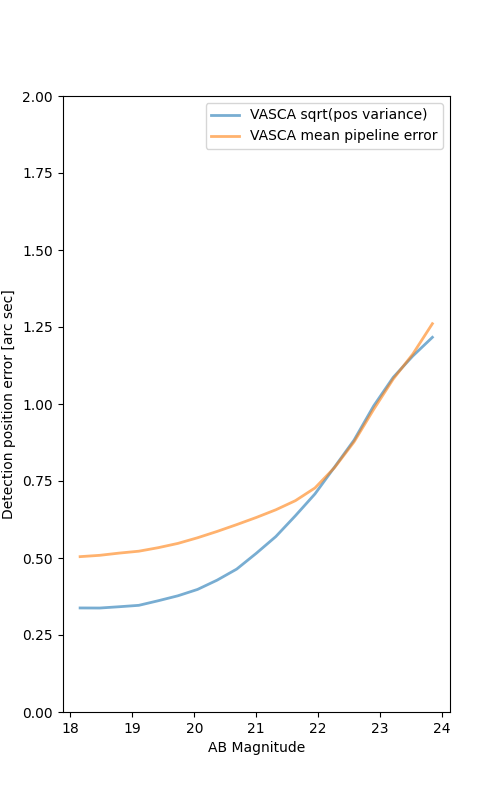

In [5]:
#Source selection
sel_cpval = tt_srcs["flux_cpval"]>0.01
#sel_field = tt_srcs["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = tt_srcs["nr_det"]>4
sel_all =  sel_cpval*sel_ndet #*sel_field #np.ones(len(tt_srcs),dtype=bool) #

pos_var_hist, _ = np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False, weights = np.sqrt(tt_srcs["pos_var"][sel_all]) )
pos_err_hist, _ = np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False, weights = tt_srcs["pos_err"][sel_all]*np.sqrt(tt_srcs["nr_det"][sel_all]))
pos_var_entries, _ = np.histogram(tt_srcs["mag"][sel_all], bins=mag_bins, density=False)

#Plot
fig_pos_var = plt.figure("pos_err",figsize=(5, 8), clear=True)
plt.plot(mag_bins_mean , pos_var_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA sqrt(pos variance)")
plt.plot(mag_bins_mean , pos_err_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA mean pipeline error")
plt.xlabel("AB Magnitude")
plt.ylabel("Detection position error [arc sec]")
plt.legend()
#plt.xlim([15, 23])
plt.ylim([0, 2.0])
fig_pos_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_pos_err.pdf")
#plt.semilogy()

### Show position and flux normalized excess variance

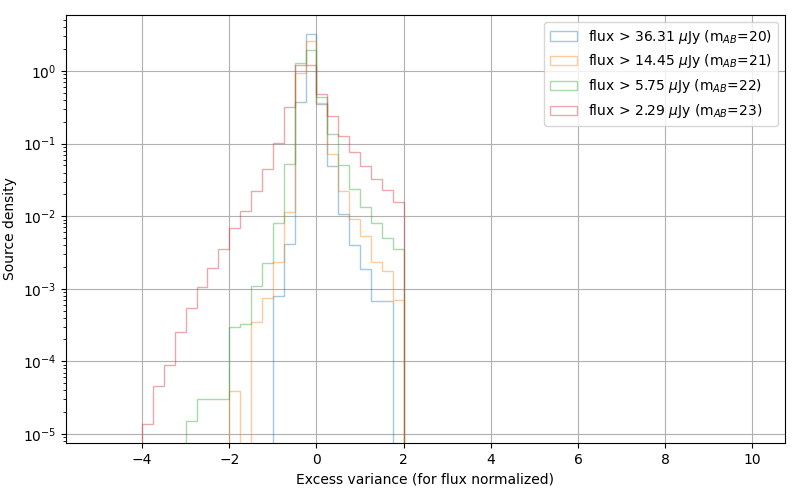

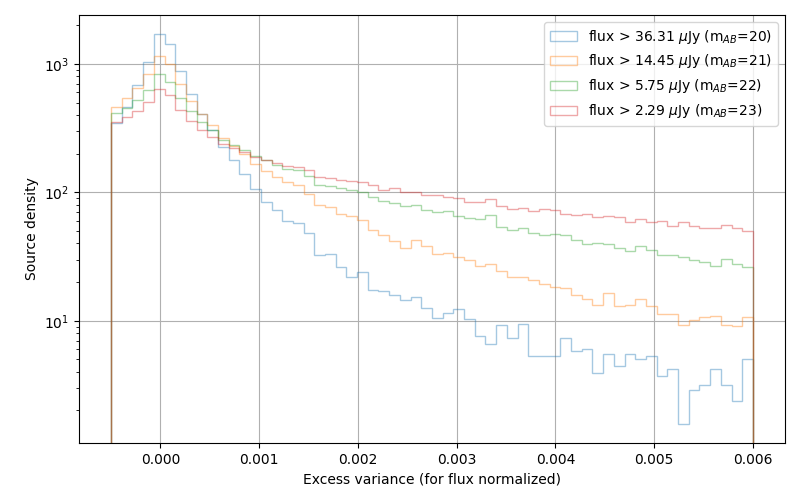

In [10]:
var_nxv = ["pos","flux"] #"pos" # 
nxv_bins = {"pos":np.linspace(-5, 10, 61),
            "flux":np.linspace(-0.0005, 0.006, 61)}
cumulative = False
for var in var_nxv:
    # Plot excess variance for different magnitude levels
    fig_flux_nxv = plt.figure(num=var+"_nxv",figsize=(8, 5), clear=True)
    flux_range = mag2flux(range(20,24))
    for flux_cut in flux_range:
        sel_flux = (tt_srcs["flux"]>flux_cut)
        str_cut = str(round(flux_cut.value,2))
        str_mag_cut =  r" (m$_{AB}$="+str(int(flux2mag(flux_cut).value))+")"
        #axs[1].hist(tt_srcs[sel_flux][var+"_cpval"], bins=pval_bins_lin, density=True ,label=r"flux > "+str_cut+" $\mu$Jy",alpha=0.4)   #, ,cumulative=1
        if var == "pos":
            plt.hist(tt_srcs[sel_flux][var+"_xv"], bins=nxv_bins[var], density=True ,label=r"flux > "+str_cut+" $\mu$Jy" + str_mag_cut,alpha=0.4,cumulative=cumulative , histtype="step")   #, 
        else:
            plt.hist(tt_srcs[sel_flux][var+"_nxv"], bins=nxv_bins[var], density=True ,label=r"flux > "+str_cut+" $\mu$Jy"+ str_mag_cut,alpha=0.4,cumulative=cumulative , histtype="step")  
    plt.ylabel("Source density")
    plt.xlabel("Excess variance (for flux normalized)")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()
    plt.grid()
    plt.show()

### Make delta time distribution between light curve points

In [7]:
if show_dtime_dist:
    src_ids = tt_srcs["rg_src_id"][tt_srcs["sel"]]
    dd_lcs = rg.get_light_curve(rg_src_ids=src_ids)
    ll_lgdtbins = np.linspace(-2,4,1200)
    hist_lgdt = np.zeros(len(ll_lgdtbins)-1, dtype=np.int64)
    #Loop over sources adn hsitogram all delta time combinations
    for src_id, tt_lc in dd_lcs.items():
        times = tt_lc["time"][tt_lc["obs_filter_id"]==obs_filter_id]
        times = np.sort(times)
        dtimes = (times[1:].data[None, :] - times[:-1].data[:, None]).flatten()
        lgdt = np.log10(dtimes)
        hist_add, _ = np.histogram(lgdt,bins=ll_lgdtbins)
        hist_lgdt  = hist_lgdt + hist_add
    times = np.power(10,(ll_lgdtbins[:-1]+ ll_lgdtbins[1:])/2)

In [8]:
if show_dtime_dist:
#Plot
    fig, ax = plt.subplots(1,1,figsize=(8, 6),squeeze=True, num="Delta time distribution", clear=True)
    #ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Frequency [1/day]")
    ax.set_ylabel("Nr. of entries")
    ax.plot(1/times,hist_lgdt)
    secax = ax.secondary_xaxis("top", functions=(freq2period, period2freq))
    secax.set_xlabel("Period [day]")
    plt.show()

In [9]:
np.sqrt(0.002)

0.044721359549995794